# Assignment

1. Train a classification models of your own dataset, and calculate F-score. (Select from one of the three models that fit your dataset properly.)
2. When the training set is small, we usually perform a cross-validation task for training the model. Assume that your own dataset is small, and train the model with 10-fold cross-validation. Calcuate its F-score. (Note that the you'll need to use the training set for cross-validation, instead of the whole dataset.) You might want to check on this document for [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).
3. Work on bootstraping for the test set. Bootstrap 300 times, and each time the subset should include at least 200 samples. Record every F-scores during bootstraping and draw a line chart as shown [here](https://www.analyticsvidhya.com/blog/2020/02/what-is-bootstrap-sampling-in-statistics-and-machine-learning/). Don't forget to output an average F-score of the 300 times bootstraping.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
from random import choices
from statistics import mean 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score

### Model Training (without 10-fold cross-validation)

* 此份資料為信用卡用戶資料（從 Kaggle 取得）
* 此次分類任務為透過用卡人之基本資訊（包含使用現況、年齡、性別、教育程度、婚姻狀況、卡別、卡片額度等等），去預測用卡人之薪水區間
* 由於原始資料將薪水區間分得過細，故重新整理薪水區間之資料，刪除「Unknown」和「Less than 40K」，並將 80K-120K 和 120K 以上標示為「high」，剩下為「normal」的二元分類，置於 「label」 欄位
* 因為是二元分類，且多為連續值之資料，故選用 GaussianNB 訓練

In [2]:
# read the csv

card = pd.read_csv('/Users/biaoyun/Documents/111 Spring Semester Gtaduated Institute/Data/BankChurners.csv', sep=',', index_col=0)
card.drop(card.columns[[13, 14, 15, 16, 17, 18, 19, 20, 21]], axis=1, inplace=True)
card = card[card.Income_Category != 'Unknown']
card = card[card.Income_Category != 'Less than $40K']

income_c = []

for income in card['Income_Category']:
    if income == '$80K - $120K':
        income_c.append('high')
    elif income == '$120K +':
        income_c.append('high')
    else:
        income_c.append('normal')

card['label'] = income_c
card.drop(card.columns[[6]], axis=1, inplace=True)

card

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,label
CLIENTNUM,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,Blue,39,5,1,3,12691.0,normal
713982108,Existing Customer,51,M,3,Graduate,Married,Blue,36,4,1,0,3418.0,high
709106358,Existing Customer,40,M,3,Uneducated,Married,Blue,21,5,1,0,4716.0,normal
713061558,Existing Customer,44,M,2,Graduate,Married,Blue,36,3,1,2,4010.0,normal
810347208,Existing Customer,51,M,4,Unknown,Married,Gold,46,6,1,3,34516.0,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
713755458,Attrited Customer,50,M,1,Unknown,Unknown,Blue,36,6,3,4,9959.0,high
710841183,Existing Customer,54,M,1,High School,Single,Blue,34,5,2,0,13940.0,normal
772366833,Existing Customer,50,M,2,Graduate,Single,Blue,40,3,2,3,4003.0,normal


In [3]:
card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5454 entries, 768805383 to 717406983
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            5454 non-null   object 
 1   Customer_Age              5454 non-null   int64  
 2   Gender                    5454 non-null   object 
 3   Dependent_count           5454 non-null   int64  
 4   Education_Level           5454 non-null   object 
 5   Marital_Status            5454 non-null   object 
 6   Card_Category             5454 non-null   object 
 7   Months_on_book            5454 non-null   int64  
 8   Total_Relationship_Count  5454 non-null   int64  
 9   Months_Inactive_12_mon    5454 non-null   int64  
 10  Contacts_Count_12_mon     5454 non-null   int64  
 11  Credit_Limit              5454 non-null   float64
 12  label                     5454 non-null   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 5

In [5]:
card.to_csv('/Users/biaoyun/Documents/111 Spring Semester Gtaduated Institute/Data/card.csv', sep = '\t')

In [4]:
# apply label encoder
# select features 
# only 9 features were chosen

card['Attrition_Flag'] = LabelEncoder().fit_transform(card.Attrition_Flag.values)
card['Gender'] = LabelEncoder().fit_transform(card.Gender.values)
card['Education_Level'] = LabelEncoder().fit_transform(card.Education_Level.values)
card['Marital_Status'] = LabelEncoder().fit_transform(card.Marital_Status.values)
card['Card_Category'] = LabelEncoder().fit_transform(card.Card_Category.values)
card['label'] = LabelEncoder().fit_transform(card.label.values)

features = card[["Attrition_Flag", "Customer_Age" , "Gender", "Dependent_count", "Education_Level", "Card_Category", "Months_on_book", "Months_Inactive_12_mon", "Credit_Limit"]]
target = card["label"] 

* 這邊將 features & target 都換成 numpy array，為了方便最後做 bootstrapping 取樣

In [5]:
features = features.to_numpy()
target = target.to_numpy()

In [6]:
# separate dataset into training and test sets (80:20)


features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 413)


In [7]:
modelg = GaussianNB()   # initialize the model
GausNB = modelg.fit(features_train, target_train)   # train the model

### Model Evaluation

* 畫出 confusion matrix 以及 classification report (包含 accuracy、precision、recall 和 f-score)

In [8]:
# evaluate the performance


predict_Gnb = GausNB.predict(features_test)


print(confusion_matrix(target_test, predict_Gnb))
print(classification_report(target_test, predict_Gnb, target_names=['normal', 'high']))

[[274 189]
 [ 98 530]]
              precision    recall  f1-score   support

      normal       0.74      0.59      0.66       463
        high       0.74      0.84      0.79       628

    accuracy                           0.74      1091
   macro avg       0.74      0.72      0.72      1091
weighted avg       0.74      0.74      0.73      1091



In [9]:

def model_metrics(prediction, label): 
    
    print(ConfusionMatrixDisplay.from_predictions(label, prediction, cmap = "Wistia")) 
    evaluation = precision_recall_fscore_support(label, prediction, average='macro') 
    accuracy = accuracy_score(label, prediction) # 計算accuracy

    print("accuracy: " + str(round(accuracy, 2)) + "\nprecision: " + str(round(evaluation[0], 2)) + "\nrecall: " + str(round(evaluation[1], 2)) + "\nfscore: " + str(round(evaluation[2],2)))

accuracy: 0.74
precision: 0.74
recall: 0.72
fscore: 0.72


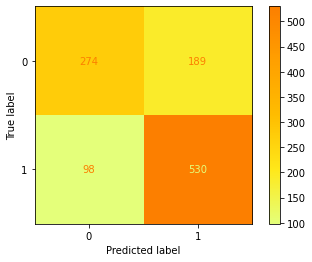

In [10]:
model_metrics(predict_Gnb, target_test)

### Model Training (with 10-fold cross-validation)

* 在 training set 上做 10-fold cross-validation
* 回傳 10-fold cross-validation 後的各項資訊

In [11]:
ac = cross_val_score(GausNB, features_train, target_train, cv=10, scoring='accuracy')
pr = cross_val_score(GausNB, features_train, target_train, cv=10, scoring='average_precision')
re = cross_val_score(GausNB, features_train, target_train, cv=10, scoring='recall')
f1 = cross_val_score(GausNB, features_train, target_train, cv=10, scoring='f1_macro')
print("Accuracy: %0.2f (+/- %0.2f)" % (ac.mean(), ac.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (pr.mean(), pr.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (re.mean(), re.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))

Accuracy: 0.71 (+/- 0.04)
Precision: 0.86 (+/- 0.03)
Recall: 0.82 (+/- 0.04)
F1-score: 0.68 (+/- 0.05)


### Bootstrapping

* bootstrapping 300 次
* 樣本大小從 200 開始至 500
* 取其 f-score 成績

In [12]:
# bootstrap predictions


f_score =[]
sample_list = []

for size in range(200, 500) :
    features_test_bs = choices(features_test, k=size)
    target_test_bs = choices(target_test, k=size)
    # make predictions
    predict_Gnb_bs = GausNB.predict(features_test_bs)
    # evaluate model
    score = f1_score(target_test_bs, predict_Gnb_bs)
    f_score.append(score)
    sample_list.append([size, mean(f_score)])
    


* 畫出 bootstrapping f-score 與取樣大小、次數之圖
* 可以發現一開始浮動非常大，f-score 很不固定，待 bootstrapping 次數增加、每次隨機抽取之樣本數越來越大，浮動也漸趨平緩
* 大約在取樣大小 300、bootstrapping 100 次左右時結果開始收斂

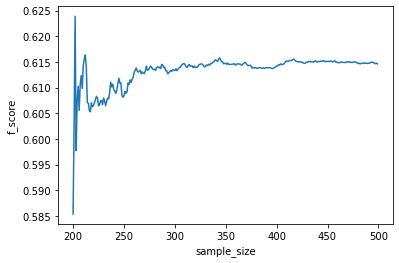

In [13]:
data = pd.DataFrame(sample_list, f_score, columns = ['sample_size', 'f_score'])
ax = sns.lineplot(data = data, x = 'sample_size', y = 'f_score');

* 算出 300 次的 f-score 平均

In [14]:
# average 300 times f-score

average_f_score = mean(f_score)
average_f_score

0.6146086827562783

### Reflection

* 透過 10-fold cross-validation 和 bootstrapping 可以發現，訓練模型時將資料切分並訓練 or test 多次時比較能看到模型平均表現，而非像最一開始什麼都沒做的結果那麼武斷
* 此例中明顯看出取樣越多次越能達到平均，（什麼都沒有的f-score:0.72 最高，其次是 10-fold cross-validation 約在 0.68，而 300 次的 bootstrapping 的 平均0.61 則最低）
* 不過也許要取樣的部分一致會比較好拿來比較 XD